# RecoGym

RecoGym is a Python [OpenAI Gym](https://gym.openai.com/) environment for testing recommendation algorithms.  It allows for the testing of both offline and reinforcement-learning based agents.  It provides a way to test algorithms in a toy environment quickly.


In [1]:
from numpy.random.mtrand import RandomState
from recogym import Configuration
from recogym.agents import Agent
from sklearn.linear_model import LogisticRegression
from recogym import verify_agents
from recogym.envs.session import OrganicSessions
from recogym.agents import FeatureProvider, OrganicUserEventCounterAgent, organic_user_count_args
from recogym.agents import RandomAgent, random_args
from recogym.evaluate_agent import verify_agents, plot_verify_agents
import math
import numpy as np
from recogym import Configuration, DefaultContext, Observation
from recogym.envs.session import OrganicSessions

import gym, recogym
from copy import deepcopy
from recogym import env_1_args
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline

num_users = 2000
num_products = 10

# You can overwrite environment arguments here:
env_1_args['random_seed'] = 42
env_1_args['num_products'] = num_products
env_1_args['number_of_flips'] = num_products // 2
env_1_args['sigma_mu_organic'] = 3
env_1_args['sigma_omega'] = 0.1

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [ ]:
# If you are not running it on google colab, you can skip this cell
os.chdir('bandit-reco/notebooks')
!git clone https://github.com/criteo-research/bandit-reco.git

In [2]:
from util import FullBatchLBFGS

## Data generation

In [3]:
data = env.generate_logs(num_users)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 2000/2000 [00:26<00:00, 74.54it/s] 


In [4]:
# data = deepcopy(env).generate_logs(num_users)

In [5]:
data.head(5)

,t,u,z,v,a,c,ps,ps-a
0,0.0,0,organic,0,<NA>,NaN,NaN,None
1,1.0,0,bandit,<NA>,3,0.0,0.1,()
2,2.0,0,bandit,<NA>,4,0.0,0.1,()
3,3.0,0,bandit,<NA>,5,0.0,0.1,()
4,4.0,0,bandit,<NA>,0,0.0,0.1,()


The logs generated by recogym contain the events with the following information:
   * `t` is the timestep (always incremented)
   * `u` is the user id linked to this event, in this data sample, we have only one user, hence it is always 0.
   * `z` in the type of event (either organic: the user views a product or bandit: the user interact with a recommendation made by the agent).
   * `v` is the index of the viewed product. Defined only if `z = organic`.
   * `a` is a number between `0` and `num_products - 1` that references the index of the product that was recommended by the agent. Defined only if `z = bandit`.
   * `c` is either `0` or `1` and denotes if the recommendation was clicked or not. This is typically what we want our agent to maximize. Defined only if `z = bandit`.
   * `ps` is the propensity score or the probability that the agent assigned to this action. Here this propensity score always equals `0.1` since the agent was picking randomly the product to display. Defined only if `z = bandit`.
   * `ps-a` can be ignored for today.

## Agent evaluation

We will use the popularity agent as the baseline. It basically predict the organic product that has been seen the most so far by the user. It is a simple but actually strong baseline.

In [6]:
organic_counter_agent = OrganicUserEventCounterAgent(
    Configuration({**organic_user_count_args, 'select_randomly': False, 'exploit_explore': False, 'epsilon': 0.0}))

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [01:14<00:00, 66.75it/s] 


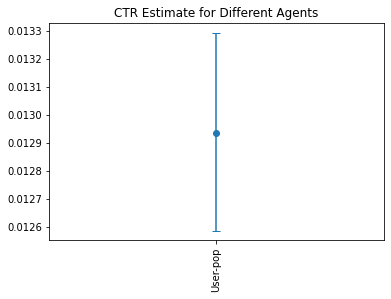

In [7]:
N_USERS_AB_TEST = 5000
result_AB = verify_agents(env, N_USERS_AB_TEST, {'User-pop': organic_counter_agent})
plot_verify_agents(result_AB)
None

# Logistic Regression Model

## Turn Data into Features

Now we are going to build a _Logistic Regression_ model.

The model will predict _the probability of the click_ for the following data:
* _`Views`_ is a total amount of views of a particular _`Product`_ shown during _Organic_ _`Events`_ **before** a _Bandit_ _`Event`_.
* _`Action`_ is a proposed _`Product`_ at a _Bandit_ _`Event`_.

For example, assume that we have _`10`_ products. In _Organic_ _`Events`_ , these products  were shown to a user as follows:

| Product Id | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8  | 9 |
|------------|---|---|---|---|---|---|---|---|----|---|
| Views      | 0 | 0 | 0 | 7 | 0 | 0 | 0 | 8 | 11 | 0 |

When we want to know the probability of the click for _`Product`_ = _`8`_ with available amounts of _`Views`_ , the input data for the model will be:

$v = $_`0 0 0 7 0 0 0 8 11 0`_ and _**`8`**_

The first `10` numbers are _`Views`_ of _`Products`_ (see above), the latest one is the _`Action`_.

We will try to predict: $\mathbb{P}(C|P=p, V)$ that is the probability of the click for a _`Product`_ $p$, provided that we have _`Views`_ $V$.

We will encode _`Action`_ using a one-hot encoding.
In our current example, the _`Action`_ is _`8`_. Thus, it is encoded as:

_$a = $`0 0 0 0 0 0 0 0`_ _**`1`**_ _`0`_

Here,
* Vector of _`Actions`_ has a size that is equal to the _*number of `Products`*_ i.e., _`10`_.
* _`Action`_ _`8`_ is marked as _`1`_ (_`Action`_ starts with _`0`_ ).

Numerically, to fully describe the context $P=p, V$ that mixes the evaluated product and the products seen by the user, we do a Kronecker product of the two vectors $a$ and $v$. 
Namely, the vector used as features is the flattened version of the following $P \times P$ matrix
$$
\begin{pmatrix}
\cdots & 0      & \cdots \\
  & \vdots & \\
\cdots & v & \cdots \\
  & \vdots & \\
\cdots & 0      & \cdots
\end{pmatrix}
\leftarrow \text{ only the line corresponding the the action $p$ is non zero}
$$

In [8]:
class ProductCountFeatureProvider(FeatureProvider):
    """This feature provider creates a user state based on viewed product count.
    Namely, the feature vector of shape (n_products, ) contains for each product how many times the
    user has viewed them organically.
    """

    def __init__(self, config):
        super(ProductCountFeatureProvider, self).__init__(config)
        self.feature_data = np.zeros((self.config.num_products)).astype(int)

    def observe(self, observation):
        for session in observation.sessions():
            self.feature_data[int(session['v'])] += 1

    def features(self, observation):
        return self.feature_data.copy()

    def reset(self):
        self.feature_data[:] = 0


def build_rectangular_data(logs, feature_provider):
    """Create a rectangular feature set from the logged data.
    For each taken action, we compute the state in which the user was when the action was taken
    """
    feature_provider.reset()
    user_states, actions, rewards, proba_actions = [], [], [], []
    
    current_user = None
    for _, row in logs.iterrows():
        if current_user != row['u']:
            # Use has changed: start a new session and reset user state
            current_user = row['u']
            sessions = OrganicSessions()
            feature_provider.reset()
        
        context = DefaultContext(row['u'], row['t'])
        
        if row['z'] == 'organic':
            sessions.next(context, row['v'])
            
        else:
            # For each bandit event, generate one observation for the user state, the taken action
            # the obtained reward and the used probabilities
            feature_provider.observe(Observation(context, sessions))
            user_states += [feature_provider.features(None)] 
            actions += [row['a']]
            rewards += [row['c']]
            proba_actions += [row['ps']] 
            
            # Start a new organic session
            sessions = OrganicSessions()
    
    return np.array(user_states), np.array(actions).astype(int), np.array(rewards), np.array(proba_actions)

In [9]:
# You can now see data that will be provided to our agents based on logistic regressions.
config = Configuration(env_1_args)
count_feature_provider = ProductCountFeatureProvider(config=config)

rectangular_logs = build_rectangular_data(data, count_feature_provider)
user_states, actions, rewards, proba_actions = rectangular_logs

In [10]:
preview_start, preview_size = 540, 5

print('User product views count at action time:')
print(user_states[preview_start:preview_start + preview_size])
print('Taken actions: ', actions[preview_start:preview_start + preview_size])
print('Obtained rewards: ', rewards[preview_start:preview_start + preview_size])
print('Probablities of the taken actions: ', proba_actions[preview_start:preview_start + preview_size])

User product views count at action time:
[[ 0  0  0  3 12  2  0  3  1  0]
 [ 0  0  0  3 12  2  0  3  1  0]
 [ 0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0]]
Taken actions:  [0 1 5 3 9]
Obtained rewards:  [0. 0. 0. 0. 0.]
Probablities of the taken actions:  [0.1 0.1 0.1 0.1 0.1]


Look at the data and see how it maps into the features - which is the combination of the history and the actions and the label, which is clicks.  Note that only the bandit events correspond to records in the training data.


## Create logistic regression agent

In [11]:
class LikelihoodAgent(Agent):
    def __init__(self, feature_provider, seed=43):
        self.feature_provider = feature_provider
        self.random_state = RandomState(seed)
        self.model = None
        
    @property
    def num_products(self):
        return self.feature_provider.config.num_products
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state"""
        features = np.zeros(len(user_state) * self.num_products)
        features[action * len(user_state): (action + 1) * len(user_state)] = user_state
        
        return features
    
    def train(self, rectangular_logs):
        user_states, actions, rewards, proba_actions = rectangular_logs
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])
        self.model = LogisticRegression(solver='lbfgs', max_iter=5000)
        self.model.fit(features, rewards)
    
    def _score_products(self, user_state):
        all_action_features = np.array([
            self._create_features(user_state, action) 
            for action in range(self.num_products)
        ])
        return self.model.predict_proba(all_action_features)[:, 1]
        
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past history"""
        self.feature_provider.observe(observation)        
        user_state = self.feature_provider.features(observation)
        prob = self._score_products(user_state)
        
        action = np.argmax(prob)
        ps = 1.0
        all_ps = np.zeros(self.num_products)
        all_ps[action] = 1.0        
        
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': ps,
                'ps-a': all_ps,
            }
        }

    def reset(self):
        self.feature_provider.reset()  

In [12]:
# Have a look at the feature vector used by the Likelihood agent.
picked_sample = 540
likelihood_logreg = LikelihoodAgent(count_feature_provider)

print('User state: ', user_states[picked_sample])
print('Action: ', actions[picked_sample])
print('Created cross features:')
print(likelihood_logreg._create_features(user_states[picked_sample], actions[picked_sample]))

User state:  [ 0  0  0  3 12  2  0  3  1  0]
Action:  0
Created cross features:
[ 0.  0.  0.  3. 12.  2.  0.  3.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [13]:
%%time

likelihood_logreg = LikelihoodAgent(count_feature_provider)
likelihood_logreg.train(rectangular_logs)

CPU times: user 18.2 s, sys: 1.4 s, total: 19.6 s
Wall time: 5.81 s


Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [01:58<00:00, 42.16it/s]


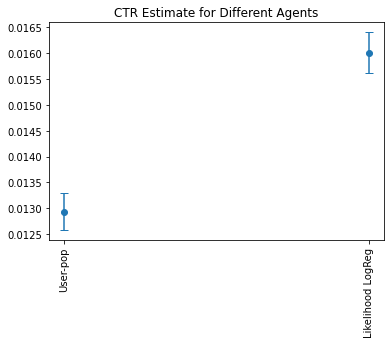

In [14]:
result_AB = pd.concat([result_AB, verify_agents(env, N_USERS_AB_TEST, {'Likelihood LogReg': likelihood_logreg})])
plot_verify_agents(result_AB)
None

So far the training was obtained with a random policy. Hence, this data was not suffering from any covariate shift and value based models such as logistic regression can safely interpolate from it.
What happens if we sample the data differently, for example with a popularity agent plus some randomness for exploration (`epsilon`)?

In [15]:
# Generate RecoGym logs for U users
logger = OrganicUserEventCounterAgent(
    Configuration({**organic_user_count_args, 'select_randomly': True, 'random_seed': 1221, 'epsilon': 0.001})
)
data = env.generate_logs(num_users, agent = logger)
rectangular_logs = build_rectangular_data(data, count_feature_provider)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 2000/2000 [00:36<00:00, 55.32it/s]


In [16]:
likelihood_logreg = LikelihoodAgent(count_feature_provider)
likelihood_logreg.train(rectangular_logs)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [01:11<00:00, 70.16it/s] 
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [01:59<00:00, 41.83it/s]


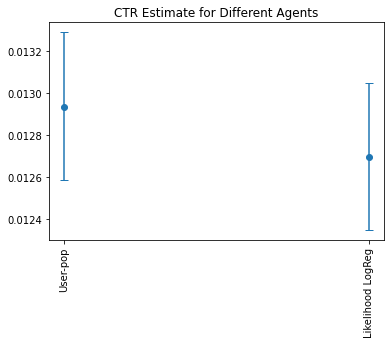

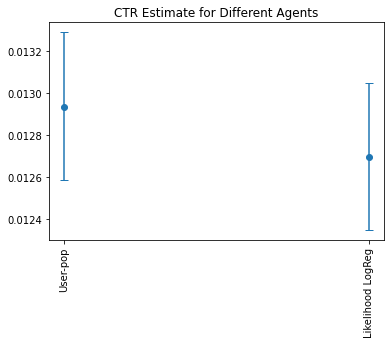

In [17]:
result_AB = verify_agents(env, N_USERS_AB_TEST, {'User-pop': organic_counter_agent})
result_AB = pd.concat([result_AB, verify_agents(env, N_USERS_AB_TEST, {'Likelihood LogReg': likelihood_logreg})])
plot_verify_agents(result_AB)
None

# Policy learning

## Contextual bandit agent

Classical value-based methods (such as logistic regression) aim to learn the probability that a given action will lead to a positive reward, that is:

$$p(c = 1|\mathbf{x},a)$$

In what follows, we will implement a different approach: a policy learning method.
Policy-learning methods do not explicitly model the probability of a positive reward, but aim to directly model the action that should be taken, given a context:

$$p(a|\mathbf{x})$$

Classical contextual bandits achieve this by optimising the expectation of the reward under the new (learned) policy $\pi_\theta$, given a logged dataset under policy $\pi_0$.
For a given dataset $\mathcal{D}$ consisting of $N$ tuples $(\mathbf{x},a,p,c)$, the objective can be written as the following:

$$\theta^{*} = \text{argmax}_{\theta} \sum_{i=1}^{N}c_i\frac{\pi_\theta(a_i|\mathbf{x}_i)}{\pi_0(a_i|\mathbf{x}_i)}$$

This objective can be straightforwardly optimised using your favourite package that provides auto-differentiation functionality.
In our example, we will use PyTorch.

In [18]:
class MultinomialLogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        torch.nn.Module.__init__(self)
        # Generate weights - initialise randomly
        self.weight = torch.nn.Parameter(torch.Tensor(output_dim, input_dim))
        # torch.nn.init.kaiming_uniform_(self.weight, a = np.sqrt(5))
        torch.nn.init.zeros_(self.weight)

    def forward(self, x):
        inner_product = F.linear(x, self.weight)
        return F.softmax(inner_product, dim = 1)

class VanillaContextualBandit(Agent):
    def __init__(self, config, P=num_products, max_epoch=30, max_weight=None):
        Agent.__init__(self, config)
        self.model = MultinomialLogisticRegressionModel(P, P)
        self.loss_history = []
        self.user_state = np.zeros(P)
        self.P = P
        self.max_epoch = max_epoch
        self.max_weight = max_weight

    def loss(self, X, a, proba_logged_actions, c):
        # Compute action predictions for clicks
        predicted_proba_for_all_actions = self.model(X)
        
        # Only keep probabilities for the actions that were taken
        predicted_proba = torch.gather(predicted_proba_for_all_actions, 1, a.unsqueeze(1)).reshape(-1)
        
        # expectation of the rewards under the new policy
        rewards = predicted_proba / proba_logged_actions
        
        if self.max_weight is not None:
            rewards = torch.clamp(rewards, min=0, max=self.max_weight)

        # Since pytorch is meant to perform convex optimization, we rather
        # output a loss that we will want to minimize
        loss = - rewards
        return loss.mean()

    def train(self, rectangular_logs):
        """Train the contextual bandit based on an offline log such that it 
        learns to minimize its loss function
        """
        user_states, actions, rewards, proba_actions = rectangular_logs
        X = user_states
        a = actions
        p = proba_actions
        c = rewards
        
        # Put into PyTorch variables - drop unclicked samples
        X = Variable(torch.Tensor(X[c != 0]))
        a = Variable(torch.LongTensor(a[c != 0]))
        w = torch.Tensor(p[c != 0])
        
        def closure():
            # Reset gradients
            optimiser.zero_grad()

            return self.loss(X, a, w, c)
        
        # Set up optimiser
        optimiser = FullBatchLBFGS(self.model.parameters())

        # Initial loss
        self.loss_history.append(closure())
        max_epoch = self.max_epoch
        for epoch in range(max_epoch):
            # Optimisation step
            obj, _, _, _, _, _, _, _ = optimiser.step({'closure': closure,
                                                       'current_loss': self.loss_history[-1],
                                                       'max_ls': 20})
            self.loss_history.append(obj)
        
        return

    def plot_loss_history(self):
        ''' Plot the training loss over epochs '''
        _,_ = plt.subplots()
        plt.plot(range(len(self.loss_history)),self.loss_history)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        
    def observe(self, observation):
        ''' Observe new organic views and capture them in the user state '''
        for session in observation.sessions():
            self.user_state[int(session['v'])] += 1

    def act(self, observation, reward, done):
        ''' Pick an action, based on the current observation and the history '''
        # Observe
        self.observe(observation)

        # Act
        p_a = self.model(torch.Tensor([self.user_state])).detach().numpy().ravel()
        action = np.argmax(p_a)
        prob = np.zeros_like(p_a)
        prob[action] = 1.0

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': 1.0,
                'ps-a': prob,
            },
        }

    def reset(self):
        ''' Reset the user state '''
        self.user_state = np.zeros(self.P)

In [19]:
vanilla_cb = VanillaContextualBandit({}, max_epoch=100)
vanilla_cb.train(rectangular_logs)

/Users/m.bompaire/Projects/bandit-reco/notebooks/Solutions/util/LBFGS.py:247: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))


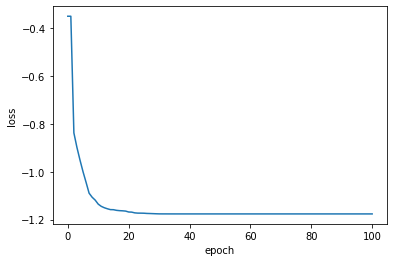

In [20]:
vanilla_cb.plot_loss_history()

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [01:48<00:00, 46.15it/s]


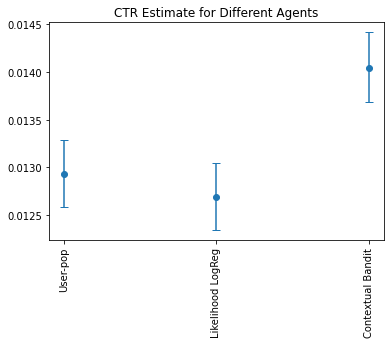

In [21]:
result_AB = pd.concat([result_AB, verify_agents(env, N_USERS_AB_TEST, {'Contextual Bandit': vanilla_cb})])
plot_verify_agents(result_AB)
None

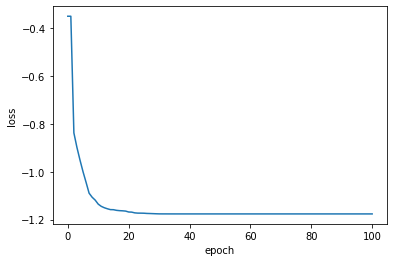

In [22]:
vanilla_cb_clamped = VanillaContextualBandit({}, max_epoch=100, max_weight=100)
vanilla_cb_clamped.train(rectangular_logs)
vanilla_cb_clamped.plot_loss_history()

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [49:51<00:00,  1.67it/s]    


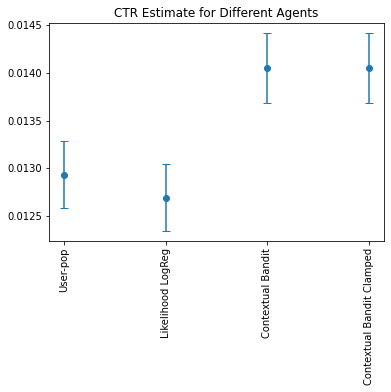

In [23]:
result_AB = pd.concat([result_AB, verify_agents(env, N_USERS_AB_TEST, {'Contextual Bandit Clamped': vanilla_cb_clamped})])
plot_verify_agents(result_AB)
None

## POEM

The classical IPS estimator has its disadvantages, however.
In its current form, the variance of the estimate can grow to be of significant size.
To mitigate this, Swaminathan and Joachims propose to include a sample variance penalisation term to the objective, effectively ensuring that the learned model does not stray too far from the logging policy.

This is the Counterfactual Risk Minimisation (CRM) objective, and the learning method optimising it directly is called POEM:
$$\theta^{*} = \text{argmax}_{\theta} \sum_{i=1}^{N}c_i\frac{\pi_\theta(a_i|\mathbf{x}_i)}{\pi_0(a_i|\mathbf{x}_i)} - \lambda \sqrt{\frac{\widehat{Var}_\theta}{N}} $$


We model $\pi_\theta$ as linear:

$$\pi_\theta(a|\mathbf{x}) = \text{softmax}(\mathbf{x}^{\intercal}\theta)_a$$


Swaminathan, Adith, and Thorsten Joachims. "Batch learning from logged bandit feedback through counterfactual risk minimization." Journal of Machine Learning Research 16.1 (2015): 1731-1755.

In [24]:
class PoemContextualBandit(VanillaContextualBandit):
    def __init__(self, config, P=num_products, max_epoch=30, variance_penalization_factor=0.):
        VanillaContextualBandit.__init__(self, config, P=num_products, max_epoch=max_epoch)
        self.variance_penalization_factor = variance_penalization_factor

    def loss(self, X, a, proba_logged_actions, c):
        # Compute action predictions for clicks
        predicted_proba_for_all_actions = self.model(X)
        
        # Only keep probabilities for the actions that were taken
        predicted_proba = torch.gather(predicted_proba_for_all_actions, 1, a.unsqueeze(1)).reshape(-1)

        loss = - predicted_proba / proba_logged_actions

        # Compute the variance of the IPS estimate
        N = loss.shape[0]
        var = torch.sqrt(torch.var(loss) / N)

        return loss.mean() + self.variance_penalization_factor * var


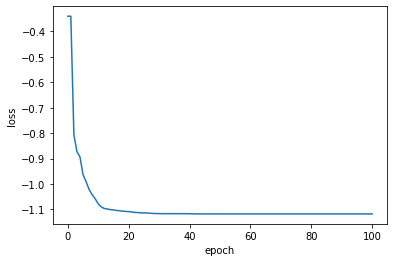

In [25]:
poem = PoemContextualBandit({}, variance_penalization_factor=1.0, max_epoch=100)
poem.train(rectangular_logs)
poem.plot_loss_history()

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 5000/5000 [02:06<00:00, 39.46it/s]


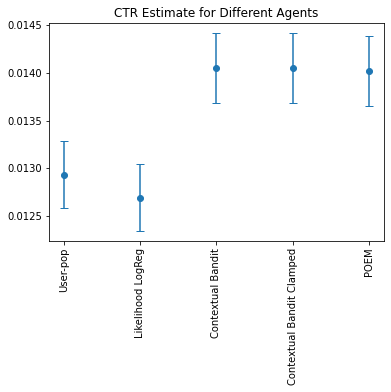

In [26]:
result_AB = pd.concat([result_AB, verify_agents(env, N_USERS_AB_TEST, {f'POEM': poem})])
plot_verify_agents(result_AB)
None